In [1]:
###Python Packages###

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.colors import LogNorm
import math as mth

import timeit
import ODE_utils as odeu
from scipy import optimize
import tables
from scipy.integrate import cumtrapz as trapint
import os
#from mpmath import *
#!jt -t onedork -cellw 100%

### Evolution Code

In [2]:
###Initial Values###

M0=1.0   ###inital mass
Q=0.9   ###charge
Lambda=0.00   ###cosmological constant
scalarfield=True   ###whether scalar field is applied at u=0 boundary
A=.075 ###amplitude of scalar field
scalarfieldtype='pulse'  ###pulse or power
power=3

In [3]:
N=25 ###Resolution in v-direction
Tol=10**(-0)/N  ###Determines the error tolerance above which the code will reduce the step size
Nul=1*N#2*N   ### Base Resolution in u-direction
scal=50  ###extra scaling on the u=0 boundary to reduce error from boundary condtions there
uscal=100   ###how often results are printed/saved to file (saved every uscal points)
umax=.1  ###max value of u that the code will go to
vmax=30  #50 ###max value of v that the code will go to

extraterms=True ###saves the derivatives of r,sig,phi to hard drive if True
rcosmtol=.00000001 ###how close the code will let r get to rcosm if u=0 initial conditions include cosmological horizon
rlim=.075

ru0=.8 ###initial value of r at (u=0,v=0)

dr0v=.1   ###the value of dr/dr at (u=0,v=0), not choosable for eddington coordinates

vbdytype="EH"   ###coordinate choice in v-direction (can choose "stan" standard, "edd" eddington)
ubdytype="stan"   ###coordinate choice in v-direction (can choose "stan" standard, "edd" eddington, "adapt" adaptive gauge) 

if vbdytype=="edd":
    dr0v=0.5*(1-2*M0/ru0+Q**2.0/ru0**2.0-Lambda/3*ru0**2.0)  ###forces dr0v to be a certain value for eddington coordinates
    
print(dr0v)


print("Max error is: "+str(Tol*umax))

0.1
Max error is: 0.004


In [4]:
###Defining Needed Constants###

scalf=float(scal)
u0=0.0
v0=0.0
rv0=ru0
phiu0=0.0
phiv0=0.0

if M0==0.0:
    dv0=1/N    
else:
    dv0=M0/N
 
if vbdytype=="EH":
    M=odeu.Mq(ru0,Q)
    M0=M

def fr(r,M0,Q,Lambda):
    return 1-2*M0/r+Q**2.0/r**2.0-Lambda*r**2.0/3.0

if Lambda>0 or Lambda<0:
    sol = optimize.root(fr,[0.687,1.3,500.0],args=(M0,Q,Lambda), method='hybr')
    rminus=sol.x[0]
    rplus=sol.x[1]
    rcosm=sol.x[2]
else:
    rplus=M0+(M0**2-Q**2)**(.5)
    rminus=M0-(M0**2-Q**2)**(.5)
    rcosm=0.0
    

wHD=True 

print("r+: "+str(rplus))
print("r-: "+str(rminus))
print("rc: "+str(rcosm))

print("Max r along u=0: "+str(ru0+vmax*dr0v))
###Predicting Run time###

###timer
start = timeit.default_timer()

Nu=Nul*umax#int(umax/du0)
Nv=int(vmax/dv0)


r+: 1.0125000000000008
r-: 0.7999999999999994
rc: 0.0
Max r along u=0: 3.8


In [5]:
extension='0'
path="data/"+extension+'/'

try:
    os.mkdir(path)
except:
    print("File already exists")

f =open(path+'/Initial-Conditions.txt','w')
f.write('###Initial Conditions###\n')
f.write('\n')
f.write('Error Based Stepping\n')
f.write('\n')
if vbdytype=='EH':
    f.write('M0='+str(M)+'\n')
else:    
    f.write('M0='+str(M0)+'\n')
f.write('Q='+str(Q)+'\n')
f.write('Lambda='+str(Lambda)+'\n')
f.write('scalarfield='+str(scalarfield)+'\n')
if scalarfield==True:
    if vbdytype=='EH':
        f.write('power='+str(power)+'\n')
    else:
        f.write('A='+str(A)+'\n')
        f.write('scalarfieldtype='+str(scalarfieldtype)+'\n')
        if scalarfieldtype=='power':
            f.write('power='+str(power)+'\n')
f.write('vbdytype='+str(vbdytype)+'\n')
f.write('ubdytype='+str(ubdytype)+'\n')
f.write('\n')
f.write('N='+str(N)+'\n')
f.write('Tol='+str(Tol)+'\n')
f.write('Nul='+str(Nul)+'\n')
f.write('scal='+str(scal)+'\n')
f.write('uscal='+str(uscal)+'\n')
f.write('umax='+str(umax)+'\n')
f.write('vmax='+str(vmax)+'\n')
f.write('\n')
f.write('r0='+str(ru0)+'\n')
f.write('drdv0='+str(dr0v)+'\n')
f.write('rlowerlimit='+str(rlim)+'\n')
f.close()

File already exists


In [6]:
##################################
###Applying Boundary Conditions###
datatype=float
rnpf=np.zeros((2,Nv),dtype=datatype)
signpf=np.zeros((2,Nv),dtype=datatype)
phinpf=np.zeros((2,Nv),dtype=datatype)
drnpvf=np.zeros((2,Nv),dtype=datatype)
dsignpvf=np.zeros((2,Nv),dtype=datatype)
dphinpvf=np.zeros((2,Nv),dtype=datatype)
drnpuf=np.zeros((2,Nv),dtype=datatype)
dsignpuf=np.zeros((2,Nv),dtype=datatype)
dphinpuf=np.zeros((2,Nv),dtype=datatype)
massnpf=np.full((2,Nv),M0)#np.zeros((2,Nv))
#drunpv=np.full((1,Nv-1),-1/(4*dr0v)*(1-2*M0/ru0+Q**2/ru0**2))

rnpf[0], signpf[0], phinpf[0] , drnpvf[0], dsignpvf[0], dphinpvf[0], drnpuf[0], dsignpuf[0], dphinpuf[0] , massnpf[0]= odeu.boundaryv(scal,ubdytype,vbdytype,Nv,ru0,dr0v,dv0,vmax,M0,Q,Lambda,scalarfield,A,rcosmtol,scalarfieldtype,power)


mask=~np.isnan(rnpf[0])
print(Nv)
rnpf=rnpf[:,mask]

Nv=int(len(rnpf[0]))
rnpf=rnpf.reshape(2,Nv)
signpf=signpf[:,mask]#.reshape(2,Nv)
phinpf=phinpf[:,mask]#.reshape(2,Nv)
dphinpuf=dphinpuf[:,mask]#.reshape(2,Nv)  
dphinpvf=dphinpvf[:,mask]#.reshape(2,Nv)
dsignpuf=dsignpuf[:,mask]#.reshape(2,Nv)
dsignpvf=dsignpvf[:,mask]#.reshape(2,Nv)
drnpuf=drnpuf[:,mask]#.reshape(2,Nv)
drnpvf=drnpvf[:,mask]#.reshape(2,Nv)
massnpf=massnpf[:,mask]#.reshape(2,Nv)
print(Nv)
#print(massnpf)

3
dr/dv is 0.8195960070223167
0.0 0.0 0.9
0.0 0.0 -0.00516619889592169 0.8195960070223167
750
750


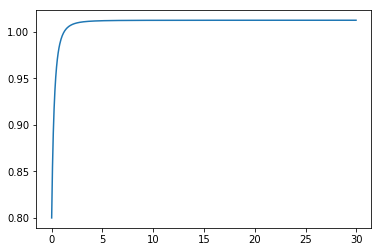

0.9062500000000001 inf
-0.00516619889592169
0.8195960070223167


In [7]:
vmax=(Nv)*dv0

vrange=np.arange(0,vmax-.00000001*vmax,dv0)#*rnpf[0])/rnpf[0]

    
plt.plot(vrange,rnpf[0])
#plt.plot(dphinpvf[0])
#plt.plot(dphinpuf[0])
Mc=np.nanmax(massnpf[0])
rcosm=odeu.rc(Mc,Q,Lambda)
plt.plot([0,vmax],[rcosm,rcosm],linestyle='--',color='green')
plt.show()



#print(vrange)
print(Mc,rcosm)
print(drnpuf[0,0])

print(drnpvf[0,0])

In [8]:
drunptemp=np.empty((Nv))*np.nan

###Applying Propagation Algorithm###

urange=np.array([0.0],dtype=datatype)



i=0
icount=0
dv=dv0
if M0>0:
    du0=M0/Nul
    #du0=M0/N
elif M0==0:
    du0=1/Nul
    #du0=1/N
du=du0


    
atom = tables.Float64Atom()

rnpfile = tables.open_file(path+'rnp.h5', mode='w',encoding="utf8") 
rnp = rnpfile.create_earray(rnpfile.root, 'data', atom, (0, Nv))
signpfile = tables.open_file(path+'signp.h5', mode='w',encoding="utf8") 
signp = signpfile.create_earray(signpfile.root, 'data', atom, (0, Nv))
phinpfile = tables.open_file(path+'phinp.h5', mode='w',encoding="utf8") 
phinp = phinpfile.create_earray(phinpfile.root, 'data', atom, (0, Nv))
massnpfile = tables.open_file(path+'massnp.h5', mode='w',encoding="utf8") 
massnp = massnpfile.create_earray(massnpfile.root, 'data', atom, (0, Nv))

if extraterms==True:
    drnpufile = tables.open_file(path+'drnpu.h5', mode='w',encoding="utf8") 
    drnpu = drnpufile.create_earray(drnpufile.root, 'data', atom, (0, Nv))
    drnpvfile = tables.open_file(path+'drnpv.h5', mode='w',encoding="utf8") 
    drnpv = drnpvfile.create_earray(drnpvfile.root, 'data', atom, (0, Nv))
    dsignpufile = tables.open_file(path+'dsignpu.h5', mode='w',encoding="utf8") 
    dsignpu = dsignpufile.create_earray(dsignpufile.root, 'data', atom, (0, Nv))
    dsignpvfile = tables.open_file(path+'dsignpv.h5', mode='w',encoding="utf8") 
    dsignpv = dsignpvfile.create_earray(dsignpvfile.root, 'data', atom, (0, Nv))
    dphinpufile = tables.open_file(path+'dphinpu.h5', mode='w',encoding="utf8") 
    dphinpu = dphinpufile.create_earray(dphinpufile.root, 'data', atom, (0, Nv))
    dphinpvfile = tables.open_file(path+'dphinpv.h5', mode='w',encoding="utf8") 
    dphinpv = dphinpvfile.create_earray(dphinpvfile.root, 'data', atom, (0, Nv))
    
rnp.append(rnpf[0].reshape(1,Nv))
signp.append(signpf[0].reshape(1,Nv))
phinp.append(phinpf[0].reshape(1,Nv))
massnp.append(massnpf[0].reshape(1,Nv))

if extraterms==True:
    drnpu.append(drnpuf[0].reshape(1,Nv))
    drnpv.append(drnpvf[0].reshape(1,Nv))
    dsignpu.append(dsignpuf[0].reshape(1,Nv))
    dsignpv.append(dsignpvf[0].reshape(1,Nv))
    dphinpu.append(dphinpuf[0].reshape(1,Nv))
    dphinpv.append(dphinpvf[0].reshape(1,Nv))
    
drunptemp=np.nanmax(np.abs(drnpuf[0]))     
dsigunpvalue=np.nanmax(np.abs(dsignpuf[0]))
dphiutemp=np.nanmax(np.abs(dphinpuf[0]))
druunptemp=np.nanmax(np.abs(odeu.Coneq(drnpuf[0],dsignpuf[0],dphinpuf[0],rnpf[0])))

i=0
TempTol=1 
TempTolv=1
Eres=False
if ubdytype=='adapt':
    maxsig1=signpf[0][0]-np.nanmax(signpf[0])
    maxsig2=signpf[0][0]-np.nanmax(signpf[0])
    maxsig3=signpf[0][0]-np.nanmax(signpf[0])
    print(maxsig1,maxsig2,maxsig3)
   
du=du0

drnpvf2 = np.empty(Nv)

while max(urange)<umax and i<2000000 and ~np.isnan(drnpvf[1][0]): #and rnpf[1][0]>0.0 :


    du = np.min([du,1/(1*Nul)])
    
    ###############
    ###Predictor###
    ###############
    drnpvf[1] = drnpvf[0]+du*odeu.Rfunc(drnpvf[0],drnpuf[0],rnpf[0],signpf[0],Q,Lambda)
    dsignpvf[1] = dsignpvf[0]+du*odeu.Sigfunc(drnpvf[0],drnpuf[0],dphinpuf[0],dphinpvf[0],rnpf[0],signpf[0],Q)
    dphinpvf[1] = dphinpvf[0]+du*odeu.Phifunc(drnpvf[0],drnpuf[0],dphinpuf[0],dphinpvf[0],rnpf[0])
    drnpuf[1] = drnpuf[0]+du*odeu.Coneq(drnpuf[0],dsignpuf[0],dphinpuf[0],rnpf[0])
    
    rnpf[1] = rnpf[0]+1/2*du*(drnpuf[0]+drnpuf[1])
    
    #if ubdytype=='adapt':
        #dsignpuf[1][0] = -(signpf[1][-1]-np.log(drnpvf[1][-1])+3/2*np.log(2))
    if ubdytype=='edd':
        dsignpuf[1][0] = 2*(3*Q**2-3*M0*rnpf[1][0]+rnpf[1][0]**4*Lambda)/(rnpf[1][0]*(-3*Q**2+rnpf[1][0]*(6*M0-3*rnpf[1][0]+rnpf[1][0]**3*Lambda)))*drnpuf[1][0]
    elif ubdytype=='stan':
        dsignpuf[1][0] = 0.0
    
    signpf[1] = signpf[0]+du*dsignpuf[0]
    phinpf[1] = phinpf[0]+du*dphinpuf[0]
    
    #drnpvf[1][0] = -1/(4*drnpuf[1][0])*np.exp(signpf[1][0])*(1-2*M0/rnpf[1][0]+Q**2/rnpf[1][0]**2-Lambda*rnpf[1][0]**2/3)
    #drnpvf[1][0] = drnpvf[0][0]+du*odeu.Rfunc(drnpvf[0][0],drnpuf[0][0],rnpf[0][0],signpf[0][0],Q,Lambda)
    #drnpvf[1] = np.exp(signpf[1])*(drnpvf[1][0]*np.exp(-signpf[1][0])-dv*trapint(rnpf[1]*(dphinpvf[1])**2.0*np.exp(-signpf[1]),initial=0))
    
    dphinpuf[1] = 1/(rnpf[1])*(rnpf[1][0]*dphinpuf[1][0]-dv*trapint(drnpuf[1]*dphinpvf[1],initial=0))
    Sigfuncnp = odeu.Sigfunc(drnpvf[1],drnpuf[1],dphinpuf[1],dphinpvf[1],rnpf[1],signpf[1],Q)
    dsignpuf[1] = dsignpuf[1][0]+dv*trapint(Sigfuncnp,initial=0)
 
    #####################################
    ###Coarse Grid (to estimate error)###
    drnpvf2 = drnpvf[0]+2*du*odeu.Rfunc(drnpvf[0],drnpuf[0],rnpf[0],signpf[0],Q,Lambda)
    dsignpvf2 = dsignpvf[0]+2*du*odeu.Sigfunc(drnpvf[0],drnpuf[0],dphinpuf[0],dphinpvf[0],rnpf[0],signpf[0],Q)
    dphinpvf2 = dphinpvf[0]+2*du*odeu.Phifunc(drnpvf[0],drnpuf[0],dphinpuf[0],dphinpvf[0],rnpf[0])
    drnpuf2 = drnpuf[0]+2*du*odeu.Coneq(drnpuf[0],dsignpuf[0],dphinpuf[0],rnpf[0])
    
    rnpf2 = rnpf[0]+du*(drnpuf[0]+drnpuf2)
    signpf2 = signpf[0]+2*du*dsignpuf[0]
    phinpf2 = phinpf[0]+2*du*dphinpuf[0]
    
    #drnpvf2[0] = -1/(4*drnpuf2[0])*np.exp(signpf2[0])*(1-2*M0/rnpf2[0]+Q**2/rnpf2[0]**2-Lambda*rnpf2[0]**2/3)
    #drnpvf2[0] = drnpvf[0][0]+2*du*odeu.Rfunc(drnpvf[0][0],drnpuf[0][0],rnpf[0][0],signpf[0][0],Q,Lambda)
    #drnpvf2 = np.exp(signpf2)*(drnpvf2[0]*np.exp(-signpf2[0])-dv*trapint(rnpf2*(dphinpvf2)**2.0*np.exp(-signpf2),initial=0))
    
    
    dphinpuf2 = 1/(rnpf2)*(rnpf2[0]*dphinpuf[1][0]-dv*trapint(drnpuf2*dphinpvf2,initial=0))
    Sigfuncnp = odeu.Sigfunc(drnpvf2,drnpuf2,dphinpuf2,dphinpvf2,rnpf2,signpf2,Q)
    dsignpuf2 = dsignpuf[1][0]+dv*trapint(Sigfuncnp,initial=0)
    ###Corrector for Coarse Grid####
    
    drnpvf2 = drnpvf[0]+du*(odeu.Rfunc(drnpvf[0],drnpuf[0],rnpf[0],signpf[0],Q,Lambda)+odeu.Rfunc(drnpvf2,drnpuf2,rnpf2,signpf2,Q,Lambda))
    dsignpvf2 = dsignpvf[0]+du*(odeu.Sigfunc(drnpvf[0],drnpuf[0],dphinpuf[0],dphinpvf[0],rnpf[0],signpf[0],Q)+odeu.Sigfunc(drnpvf2,drnpuf2,dphinpuf2,dphinpvf2,rnpf2,signpf2,Q))
    dphinpvf2 = dphinpvf[0]+du*(odeu.Phifunc(drnpvf[0],drnpuf[0],dphinpuf[0],dphinpvf[0],rnpf[0])+odeu.Phifunc(drnpvf2,drnpuf2,dphinpuf2,dphinpvf2,rnpf2))
    drnpuf2 = drnpuf[0]+du*(odeu.Coneq(drnpuf[0],dsignpuf[0],dphinpuf[0],rnpf[0])+odeu.Coneq(drnpuf2,dsignpuf2,dphinpuf2,rnpf2))
    
    rnpf2 = rnpf[0]+du*(drnpuf[0]+drnpuf2)
    signpf2 = signpf[0]+du*(dsignpuf[0]+dsignpuf2)
    phinpf2 = phinpf[0]+du*(dphinpuf[0]+dphinpuf2)
    
    #drnpvf2[0] = -1/(4*drnpuf2[0])*np.exp(signpf2[0])*(1-2*M0/rnpf2[0]+Q**2/rnpf2[0]**2-Lambda*rnpf2[0]**2/3)
    #drnpvf2[0] = drnpvf[0][0]+2*du*odeu.Rfunc(drnpvf[0][0],drnpuf[0][0],rnpf[0][0],signpf[0][0],Q,Lambda)
    #drnpvf2 = np.exp(signpf2)*(drnpvf2[0]*np.exp(-signpf2[0])-dv*trapint(rnpf2*(dphinpvf2)**2.0*np.exp(-signpf2),initial=0))
    
    
    dphinpuf2 = 1/(rnpf2)*(rnpf2[0]*0.0-dv*trapint(drnpuf2*dphinpvf2,initial=0))
    Sigfuncnp = odeu.Sigfunc(drnpvf2,drnpuf2,dphinpuf2,dphinpvf2,rnpf2,signpf2,Q)
    dsignpuf2 = dsignpuf[1][0]+dv*trapint(Sigfuncnp,initial=0)
    ######################################
    
    ################
    ###Corrector###
    ################
    drnpvf[1] = drnpvf[0]+1/2*du*(odeu.Rfunc(drnpvf[0],drnpuf[0],rnpf[0],signpf[0],Q,Lambda)+odeu.Rfunc(drnpvf[1],drnpuf[1],rnpf[1],signpf[1],Q,Lambda))
    dsignpvf[1] = dsignpvf[0]+1/2*du*(odeu.Sigfunc(drnpvf[0],drnpuf[0],dphinpuf[0],dphinpvf[0],rnpf[0],signpf[0],Q)+odeu.Sigfunc(drnpvf[1],drnpuf[1],dphinpuf[1],dphinpvf[1],rnpf[1],signpf[1],Q))
    dphinpvf[1] = dphinpvf[0]+1/2*du*(odeu.Phifunc(drnpvf[0],drnpuf[0],dphinpuf[0],dphinpvf[0],rnpf[0])+odeu.Phifunc(drnpvf[1],drnpuf[1],dphinpuf[1],dphinpvf[1],rnpf[1]))
    drnpuf[1] = drnpuf[0]+1/2*du*(odeu.Coneq(drnpuf[0],dsignpuf[0],dphinpuf[0],rnpf[0])+odeu.Coneq(drnpuf[1],dsignpuf[1],dphinpuf[1],rnpf[1]))
    
    rnpf[1] = rnpf[0]+1/2*du*(drnpuf[0]+drnpuf[1])
    
    signpf[1] = signpf[0]+1/2*du*(dsignpuf[0]+dsignpuf[1])
    phinpf[1] = phinpf[0]+1/2*du*(dphinpuf[0]+dphinpuf[1])
    
    if ubdytype=='edd':
        #dsignpuf[1][0]=(np.log(abs(1-2*M0/rnpf[1][0]+Q**2.0/rnpf[1][0]-Lambda*rnpf[1][0]**2.0/3))-signpf[0][0])/du
        dsignpuf[1][0] = 2*(3*Q**2-3*M0*rnpf[1][0]+rnpf[1][0]**4*Lambda)/(rnpf[1][0]*(-3*Q**2+rnpf[1][0]*(6*M0-3*rnpf[1][0]+rnpf[1][0]**3*Lambda)))*drnpuf[1][0]
    
    #drnpvf[1][0] = -1/(4*drnpuf[1][0])*np.exp(signpf[1][0])*(1-2*M0/rnpf[1][0]+Q**2/rnpf[1][0]**2-Lambda*rnpf[1][0]**2/3)
    #drnpvf[1][0] = drnpvf[0][0]+1/2*du*(odeu.Rfunc(drnpvf[0][0],drnpuf[0][0],rnpf[0][0],signpf[0][0],Q,Lambda)+odeu.Rfunc(drnpvf[1][0],drnpuf[1][0],rnpf[1][0],signpf[1][0],Q,Lambda))
    #drnpvf[1] = np.exp(signpf[1])*(drnpvf[1][0]*np.exp(-signpf[1][0])-dv*trapint(rnpf[1]*(dphinpvf[1])**2.0*np.exp(-signpf[1]),initial=0))
    
    dphinpuf[1] = 1/(rnpf[1])*(rnpf[1][0]*dphinpuf[1][0]-dv*trapint(drnpuf[1]*dphinpvf[1],initial=0))
    Sigfuncnp = odeu.Sigfunc(drnpvf[1],drnpuf[1],dphinpuf[1],dphinpvf[1],rnpf[1],signpf[1],Q)
    dsignpuf[1] = dsignpuf[1][0]+dv*trapint(Sigfuncnp,initial=0)
    
    massnpf[1] = (1+4.0*np.exp(-signpf[1])*drnpuf[1]*drnpvf[1])*rnpf[1]/2.0+np.power(Q,2.0)/(2.0*rnpf[1])-Lambda*np.power(rnpf[1],3.0)/6.0
    #####
    diff1=np.nanmax(np.abs((drnpuf[1]-drnpuf2)))#*4/3*(du)**(-1)))
    diff2=np.nanmax(np.abs((dsignpuf[1]-dsignpuf2)))#*4/3*(du)**(-1)))
    diff3=np.nanmax(np.abs((dphinpuf[1]-dphinpuf2)))#*4/3*(du)**(-1)))
    diff4=np.nanmax(np.abs((rnpf[1]-rnpf2)))#*4/3*(du)**(-1)))
    diff5=np.nanmax(np.abs((signpf[1]-signpf2)))#*4/3*(du)**(-1)))
    diff6=np.nanmax(np.abs((phinpf[1]-phinpf2)))#*4/3*(du)**(-1)))
    diff7=np.nanmax(np.abs((drnpvf[1]-drnpvf2)))#*4/3*(du)**(-1)))
    diff8=np.nanmax(np.abs((dsignpvf[1]-dsignpvf2)))#*4/3*(du)**(-1)))
    diff9=np.nanmax(np.abs((dphinpvf[1]-dphinpvf2)))#*4/3*(du)**(-1)))
    
    
    #print(diff1,diff2,diff3,diff4,diff5,diff6,diff7,diff8,diff9)
    diff=np.nanmax([diff1,diff2,diff3,diff4,diff5,diff6,diff7])
    #print(du,diff)
    ###
    
    rnpf[1][rnpf[1]<rlim]=np.nan

    if icount==uscal and diff< Tol:
        urange=np.append(urange,urange[i]+du)
        rnp.append(rnpf[1].reshape(1,Nv))
        signp.append(signpf[1].reshape(1,Nv))
        phinp.append(phinpf[1].reshape(1,Nv))
        massnp.append(massnpf[1].reshape(1,Nv))
        if extraterms==True:
            drnpu.append(drnpuf[1].reshape(1,Nv))
            drnpv.append(drnpvf[1].reshape(1,Nv))
            dsignpu.append(dsignpuf[1].reshape(1,Nv))
            dsignpv.append(dsignpvf[1].reshape(1,Nv))
            dphinpu.append(dphinpuf[1].reshape(1,Nv))
            dphinpv.append(dphinpvf[1].reshape(1,Nv))
        icount=0

        print("%.24f" % urange[i])
        #print("%.24f" % du)
        print(0.0,du)
        print(0.0,drnpuf[1][-1],dsignpuf[1][-1],odeu.Coneq(drnpuf[1][-1],dsignpuf[1][-1],dphinpuf[1][-1],rnpf[1][-1]))#,dphinpuf[1][-1])
        #print(dsignpuf[1][-1])
        print(0.0,drnpvf[1][0],drnpvf[1][-1],rnpf[1][-1])#,dphinpvf[1][-1])
        #print(odeu.Rfunc(drnpvf[1][-1],drnpuf[1][-1],rnpf[1][-1],signpf[1][-1],Q,Lambda),odeu.Coneq(drnpuf[1][-1],dsignpuf[1][-1],dphinpuf[1][-1],rnpf[1][-1]),odeu.Sigfunc(drnpvf[1][-1],drnpuf[1][-1],dphinpuf[1][-1],dphinpvf[1][-1],rnpf[1][-1],signpf[1][-1],Q))
        print('-')
        print(diff1,diff2,diff3)
        print(diff4,diff5,diff6)
        print(diff7,diff8,diff9)
        print(0.0,massnpf[1][-2])
        print('---')
        i+=1
        du=du*2
        
        if ubdytype=='adapt':
            maxsig3=maxsig2
            maxsig2=maxsig1
            maxsig1=signpf[1][0]-np.nanmax(signpf[1])

        rnpf[0]=rnpf[1]
        phinpf[0]=phinpf[1]
        signpf[0]=signpf[1]
        drnpvf[0]=drnpvf[1]
        dsignpvf[0]=dsignpvf[1]
        dphinpvf[0]=dphinpvf[1]
        drnpuf[0]=drnpuf[1]
        dsignpuf[0]=dsignpuf[1]
        dphinpuf[0]=dphinpuf[1]
        
        #break
        
        
    elif diff>Tol:
        du=du/2
        #print(du)
        #print(diff)
    else:
        #if ubdytype=='adapt':
            #maxsig3=maxsig2
            #maxsig2=maxsig1
            #maxsig1=signpf[1][0]-np.nanmax(signpf[1])
        
        rnpf[0]=rnpf[1]
        phinpf[0]=phinpf[1]
        signpf[0]=signpf[1]
        drnpvf[0]=drnpvf[1]
        dsignpvf[0]=dsignpvf[1]
        dphinpvf[0]=dphinpvf[1]
        drnpuf[0]=drnpuf[1]
        dsignpuf[0]=dsignpuf[1]
        dphinpuf[0]=dphinpuf[1]
        
        
        urange[i]=urange[i]+du
        #du=du*2
        icount+=1
    

0.003540039062499992627425
0.0 3.5400390625000004e-05
0.0 -8.79862608098531 -61.24772692330305 538.8887601775198
0.0 0.819936680287219 -0.003427068187758171 0.9773432996082794
-
0.01905670632685741 0.0041036031118864 3.0466741273993403e-06
0.0003111382044059807 0.002168262330046744 3.0145163223416205e-06
2.646786234043177e-05 0.00023612394292650551 5.247519796469646e-07
0.0 0.9062493443449785
---
0.010655517578124973007703
0.0 7.080078125000001e-05
0.0 -5.68884228730285 -60.142969102047985 342.13734274141797
0.0 0.8206182864024668 -0.006659330595127364 0.9263835628440213
-
0.024166202293392836 0.02644830814659116 1.7421897088670812e-05
0.0004019230302160226 0.004257220432225761 5.9405339691842585e-06
2.1445051006724163e-05 0.00043099378200432 1.049601137559364e-06
0.0 0.9062494042973988
---
0.017204589843749961558528
0.0 3.5400390625000004e-05
0.0 -3.8823353600116244 -56.95280600456642 221.10386297690798
0.0 0.8212394566254234 -0.007316061863108352 0.8956388515484964
-
0.00781783644624

In [9]:
rnpfile.close()
signpfile.close()
phinpfile.close()
massnpfile.close()
if extraterms==True:
    drnpufile.close()
    drnpvfile.close()
    dsignpufile.close()
    dsignpvfile.close()
    dphinpufile.close()
    dphinpvfile.close()
    
Nu=i+1

750
2
17
17


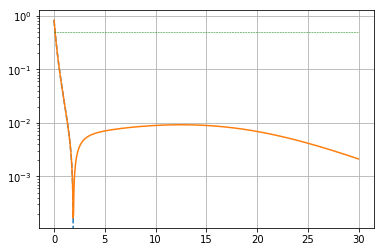

0.7994833485784296


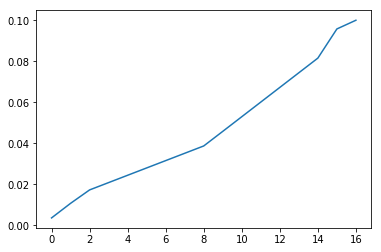

In [10]:
print(len(rnpf[0,:]))
print(len(rnpf))
print(Nu)
print(len(urange))
plt.plot(vrange,drnpvf[0],'--')
plt.plot(vrange,np.abs(drnpvf[0]))
plt.plot([vrange[0],vrange[-1]],[.5,.5],'g--',linewidth=.5)
#plt.plot(vrange,np.abs(drnpvf[1]))
plt.yscale('log')
plt.grid()
#plt.savefig('num-rel-pics/prelim-result-3-Tol=10^-3-time=55min.png',dpi=300)
plt.show()
print(rnpf[0,0])

plt.plot(urange)
plt.show()

In [11]:
switch=False
#np.save(path+'extention',extension)
np.save(path+'rnputil',np.array([N,Nu,Nv,ru0,dr0v,M0,Q,Lambda,wHD,switch,vbdytype]))
np.save(path+'urange',urange)
np.save(path+'vrange',vrange)

In [12]:
stop = timeit.default_timer()

In [13]:
acttime=stop - start

numpoints=Nu*Nv*uscal

print(str(acttime)+' seconds')
print(0.0,str((acttime)/60)+' minutes')
print(str((acttime)/3600)+' hours')

print(str(numpoints)+' points')

print(str((numpoints)/(stop - start))+' points per second') 

5.5091770209837705 seconds
0.0 0.09181961701639617 minutes
0.0015303269502732696 hours
1275000 points
231432.02608006305 points per second


conv=False
j=0
tempanswer=[]
    while conv==False:
        dv=TempTolv*dv0
        jcount=1
        while j<Nv-1:
            j1=mth.ceil(jcount*TempTolv)
            j2=mth.floor(jcount*TempTolv)
            answer=dnu.x4giveralt(0,j+mth.ceil((jcount-1)*TempTolv),du,dv*TempTolv,rnpf,phinpf,signpf,massnpf,M0,Q,Lambda,datatype)
            rnpf[1][j+j1]=answer[0]
            phinpf[1][j+j1]=answer[1]
            signpf[1][j+j1]=answer[2]
            massnpf[1][j+j1]=answer[3]
            #drunptemp[j+1]=answer[4]
            dsigunpv=answer[5]
            jcount=(jcount+1)**(0**j2)
            j=j+j2
        
        if np.abs(tempanswer[0]-answer[0])/answer[0]>0.01 or not tempanswer:
            tempanswer=answer
            TempTol=TempTolv/2
            
        else:
            conv=True
            

In [14]:
print(urange[-1])

0.10000610351562529
